In [1]:
# --- 核心库 ---
import xarray as xr
from datetime import datetime, timezone, date
from pathlib import Path
import numpy as np
import io
import matplotlib.pyplot as plt

# --- 项目模块 ---
from chromasky_toolkit import config
from chromasky_toolkit.glow_index import GlowIndexCalculator
from chromasky_toolkit.map_drawer import generate_map_from_grid
from IPython.display import display, Image, clear_output
from typing import Literal

# --- 辅助函数 ---
def print_mask_friendly(mask: xr.DataArray, downsample_factor: int = 4):
    """以友好的字符形式打印布尔掩码，用于直观展示。"""
    if not isinstance(mask, xr.DataArray) or mask.dtype != bool:
        print("错误：输入必须是布尔型的 xarray.DataArray。")
        return
    resampled_mask = mask.coarsen(
        latitude=downsample_factor, longitude=downsample_factor, boundary="pad"
    ).max().astype(bool)
    lat_coords, lon_coords, mask_values = resampled_mask.latitude.values, resampled_mask.longitude.values, resampled_mask.values
    print(" " * 5, end="")
    for i in range(0, len(lon_coords), 5): print(f"{lon_coords[i]:<5.1f}", end="")
    print("\n")
    for i, lat in enumerate(lat_coords):
        print(f"{lat:>4.1f} ", end="")
        for val in mask_values[i, :]: print('■' if val else '·', end="")
        print("")
    print(f"\n图例: ■ = 计算区域 (True), · = 非计算区域 (False)")
    print(f"注意: 图像已按因子 {downsample_factor} 降采样以适应显示。")

print("✅ 环境设置完毕。")

⚠️ Config: 未找到 .env 文件于 C:\Users\zhang\Documents\Code\chromasky-toolkit\src\.env


2025-08-08 20:08:36,420 - MapDrawer - INFO - 当前字体不支持中文，开始主动扫描系统可用中文字体...
2025-08-08 20:08:36,421 - MapDrawer - INFO - ✅ 找到可用的中文字体: 'PingFang TC'。将其设置为默认字体。
2025-08-08 20:08:36,421 - MapDrawer - INFO - 最终使用的字体列表: ['PingFang TC']


✅ 环境设置完毕。


In [2]:
# ======================================================================
# --- 核心配置区：请在此处设置您的目标参数 ---
# ======================================================================

# 1. 选择数据类型: 'past' (历史数据) 或 'future' (预报数据)
DATA_TYPE: Literal['past', 'future'] = 'past'

# 2. 设置您想分析的本地日期
#    - 对于 'past'，这是您已下载的历史日期
#    - 对于 'future'，这通常是今天或明天
TARGET_LOCAL_DATE_STR = "2025-07-22"

# 3. 设置您想分析的天文事件 ('sunrise' 或 'sunset')
EVENT_TYPE: Literal["sunrise", "sunset"] = "sunrise"

# 4. (可选) 设置模型参数
EVENT_WINDOW_MINUTES = 30
FACTORS_TO_USE = GlowIndexCalculator.ALL_FACTORS # 使用所有因子

In [3]:
# --- 1. 根据配置初始化参数 ---
target_local_date = datetime.strptime(TARGET_LOCAL_DATE_STR, "%Y-%m-%d").date()
event_times_local = config.SUNRISE_EVENT_TIMES if EVENT_TYPE == 'sunrise' else config.SUNSET_EVENT_TIMES

# *** 核心改动：根据 DATA_TYPE 确定数据的基础目录 ***
if DATA_TYPE == 'past':
    base_data_dir = config.PROCESSED_DATA_DIR / 'past'
elif DATA_TYPE == 'future':
    base_data_dir = config.PROCESSED_DATA_DIR / 'future'
else:
    raise ValueError("DATA_TYPE 必须是 'past' 或 'future'")

print("\n" + "="*80)
print(f"===== 开始为 {target_local_date} 的 {EVENT_TYPE} 事件 ({DATA_TYPE.upper()} DATA) 执行流水线 =====")
print(f"将从目录: {base_data_dir} 加载数据")
print(f"将要处理的本地时间点: {event_times_local}")
print("="*80)

# --- 2. 准备循环，一次性收集所有需要的数据 ---
generated_images, image_titles, all_individual_masks, all_glow_index_arrays = [], [], [], []

# --- 3. 遍历每个时间点，执行计算并收集结果 ---
for local_time_str in event_times_local:
    print("\n" + "-"*80)
    print(f"--- 正在处理本地时间: {local_time_str} ---")
    
    # a. 加载数据 (使用新的 base_data_dir)
    data_dir = base_data_dir / TARGET_LOCAL_DATE_STR
    time_str_for_path = local_time_str.replace(':', '')
    
    try:
        required_vars = ['hcc', 'mcc', 'lcc']
        data_arrays = {}
        for var in required_vars:
            filename = f"{var}_{time_str_for_path}.nc"
            path = data_dir / filename
            if not path.exists():
                raise FileNotFoundError(f"文件不存在: {path}")
            data_arrays[var] = xr.open_dataarray(path)
        weather_dataset = xr.Dataset(data_arrays)
        print(f"✅ 成功加载 {local_time_str} 的 {DATA_TYPE} 数据。")
        observation_time_utc = datetime.fromisoformat(weather_dataset.hcc.attrs['original_utc_time'])
    except Exception as e:
        print(f"❌ 加载数据时出错，跳过此时间点: {e}")
        continue

    # b. 计算与收集 (这部分逻辑不变)
    calculator = GlowIndexCalculator(weather_data=weather_dataset)
    active_region_mask = calculator.astro_service.create_event_mask(
        weather_dataset.latitude, weather_dataset.longitude, observation_time_utc, EVENT_TYPE, EVENT_WINDOW_MINUTES
    )
    glow_index_dataset = calculator.calculate_for_grid(
        utc_time=observation_time_utc,
        active_mask=active_region_mask,
        factors=FACTORS_TO_USE
    )
    
    # --- c. *** 核心改动：计算并打印统计数据 *** ---
    final_score_grid = glow_index_dataset['final_score']
    
    # 为了得到有意义的统计数据，我们只对活动区域内（active_mask 为 True）
    # 并且指数大于0（即头顶有云）的点进行计算。
    valid_scores = final_score_grid.where(active_region_mask & (final_score_grid > 0))
    
    if valid_scores.count() > 0: # 确保有有效值才进行计算
        min_val = valid_scores.min().item()
        max_val = valid_scores.max().item()
        mean_val = valid_scores.mean().item()
        
        print("\n--- 指数统计信息 (仅限活动区域内的有效值) ---")
        print(f"  - 最小值 (Min):   {min_val:.4f}")
        print(f"  - 最大值 (Max):   {max_val:.4f}")
        print(f"  - 平均值 (Mean):  {mean_val:.4f}")
        print("-" * 45)
    else:
        print("\n--- 指数统计信息 ---")
        print("  - 在活动区域内未计算出任何有效指数值 (>0)。")
        print("-" * 45)


    # d. 收集所有需要用于后续可视化的数据
    all_individual_masks.append(active_region_mask)
    all_glow_index_arrays.append(final_score_grid) # 收集 final_score_grid

    # e. 为独立图生成图像数据并收集
    map_title = (
        f"Glow Index ({EVENT_TYPE.capitalize()})\n"
        f"Local Time: {target_local_date} {local_time_str} ({config.LOCAL_TZ})\n"
        f"UTC Time: {observation_time_utc.strftime('%H:%M')}"
    )
    image_bytes = generate_map_from_grid(
        score_grid=final_score_grid,
        title=map_title,
        active_region_mask=active_region_mask
    )
    
    if image_bytes:
        print(f"✅ 地图生成成功！")
        generated_images.append(image_bytes)
        image_titles.append(map_title)

# 清理中间过程的输出，为最终的可视化做准备
# clear_output(wait=True)
print("✅ 所有时间点的计算和数据收集已完成。")

2025-08-08 20:08:36,618 - root - INFO - GlowIndexCalculator 初始化成功，已加载 hcc, mcc, lcc 数据。



===== 开始为 2025-07-22 的 sunrise 事件 (PAST DATA) 执行流水线 =====
将从目录: C:\Users\zhang\Documents\Code\chromasky-toolkit\src\data\processed\past 加载数据
将要处理的本地时间点: ['05:00']

--------------------------------------------------------------------------------
--- 正在处理本地时间: 05:00 ---
✅ 成功加载 05:00 的 past 数据。


2025-08-08 20:08:36,618 - chromasky_toolkit.astronomy - INFO - 正在为 sunrise 创建时间掩码，中心时间: 21:00 UTC, 窗口: ±30分钟


Calculating sunrise times:   0%|          | 0/56637 [00:00<?, ?it/s]

2025-08-08 20:08:38,400 - root - INFO - 开始为网格活动区域计算指数，使用因子: ['score_boundary', 'score_hcc', 'score_mcc', 'score_lcc']


Calculating Glow Index (4 factors):   0%|          | 0/11891 [00:00<?, ?it/s]

2025-08-08 20:11:43,427 - root - INFO - 多因子网格计算完成。
2025-08-08 20:11:43,432 - MapDrawer - INFO - --- [绘图] 开始生成地图: Glow Index (Sunrise)
Local Time: 2025-07-22 05:00 (Asia/Shanghai)
UTC Time: 21:00 ---



--- 指数统计信息 (仅限活动区域内的有效值) ---
  - 最小值 (Min):   0.0000
  - 最大值 (Max):   0.9680
  - 平均值 (Mean):  0.1033
---------------------------------------------


2025-08-08 20:11:43,736 - MapDrawer - INFO - 正在绘制活动区域掩码轮廓...


✅ 地图生成成功！
✅ 所有时间点的计算和数据收集已完成。



分时火烧云指数图 (1 张)



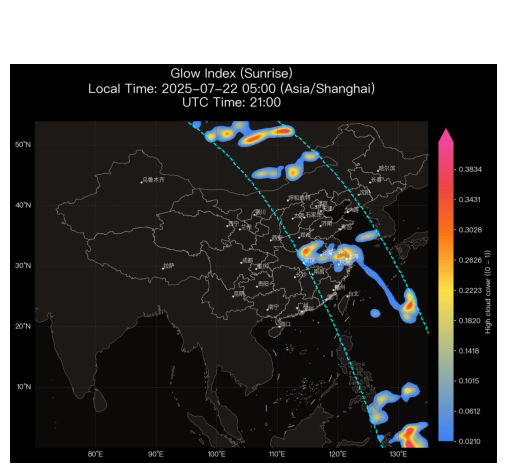

2025-08-08 20:11:45,662 - MapDrawer - INFO - --- [绘图] 开始生成地图: 综合最佳火烧云指数 (Sunrise) - PAST DATA
日期: 2025-07-22 | 时间段: 05:00 - 05:00 (Local Time) ---



综合最佳火烧云指数图



2025-08-08 20:11:45,962 - MapDrawer - INFO - 正在绘制活动区域掩码轮廓...
2025-08-08 20:11:47,244 - MapDrawer - INFO - --- [绘图] 地图已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\src\outputs\maps\glow_index\glow_index_20250722_sunrise_composite.png ---


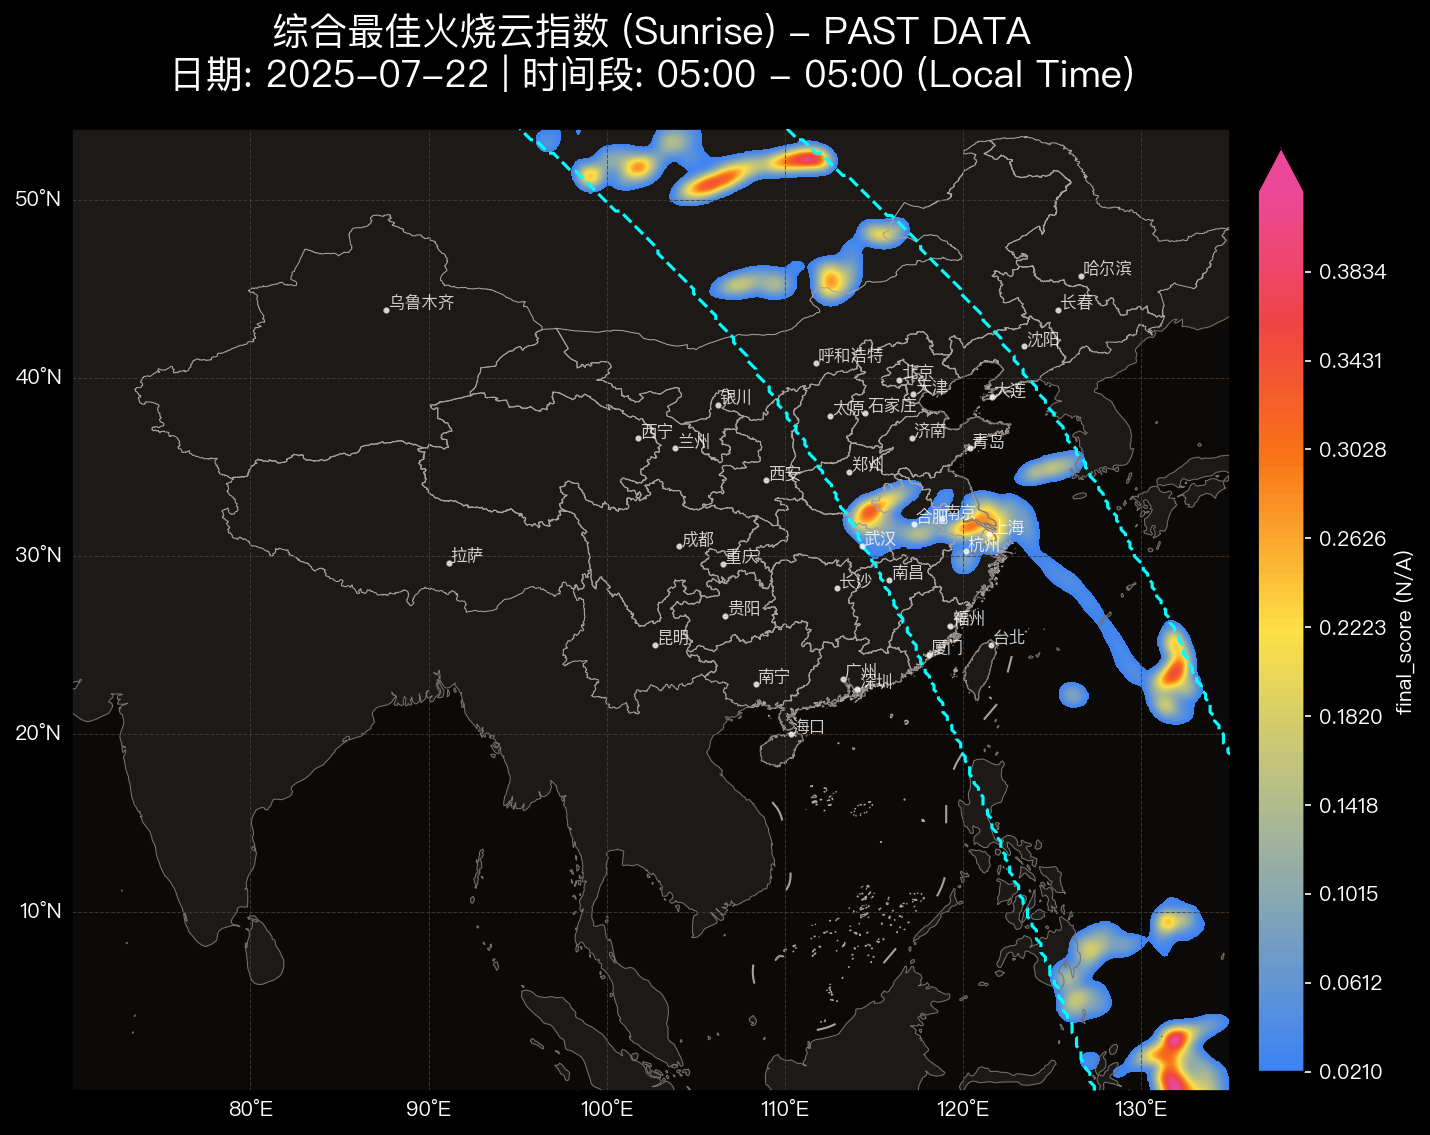

✅ 综合最佳指数地图已成功生成并保存到: outputs\maps\glow_index\glow_index_20250722_sunrise_composite.png


In [4]:
# --- 4. 统一可视化所有结果 ---

# a. 显示并排的独立时间点地图
if generated_images:
    print("\n" + "="*80)
    print(f"分时火烧云指数图 ({len(generated_images)} 张)")
    print("="*80 + "\n")
    
    num_images = len(generated_images)
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5.5))
    if num_images == 1: axes = [axes]
    for i, (img_bytes, title) in enumerate(zip(generated_images, image_titles)):
        img = plt.imread(io.BytesIO(img_bytes), format='png')
        axes[i].imshow(img)
        axes[i].set_title(title, color='white', fontsize=10)
        axes[i].axis('off')
    plt.tight_layout(pad=0.5)
    plt.show()
else:
    print("未能生成任何分时地图。")


# b. 生成并显示综合最佳指数图
if all_glow_index_arrays:
    print("\n" + "="*80)
    print("综合最佳火烧云指数图")
    print("="*80 + "\n")

    # 合并数据并计算最大值
    combined_glow_index = xr.concat(all_glow_index_arrays, dim='time').max(dim='time')
    combined_active_mask = xr.concat(all_individual_masks, dim='time').any(dim='time')

    # 准备标题和路径
    composite_map_title = (
        f"综合最佳火烧云指数 ({EVENT_TYPE.capitalize()}) - {DATA_TYPE.upper()} DATA\n"
        f"日期: {target_local_date} | 时间段: {event_times_local[0]} - {event_times_local[-1]} (Local Time)"
    )
    output_dir = config.MAP_OUTPUTS_DIR / "glow_index"
    composite_map_output_path = output_dir / f"glow_index_{target_local_date.strftime('%Y%m%d')}_{EVENT_TYPE}_composite.png"
    
    # 生成图像
    composite_image_bytes = generate_map_from_grid(
        score_grid=combined_glow_index,
        title=composite_map_title,
        output_path=composite_map_output_path,
        active_region_mask=combined_active_mask
    )
    
    if composite_image_bytes:
        display(Image(data=composite_image_bytes, width=800))
        print(f"✅ 综合最佳指数地图已成功生成并保存到: {composite_map_output_path.relative_to(config.PROJECT_ROOT)}")
    else:
        print("\n❌ 综合最佳指数地图生成失败。")
else:
    print("\n没有任何指数数据被成功计算，无法生成综合地图。")

In [12]:
# ======================================================================
# --- 单元格 5: 单点深度调试工具 ---
# ======================================================================

# --- 1. 在这里配置您想调试的单个点 ---
DEBUG_CITY_NAME = "Shanghai"
DEBUG_LAT = 31.962549452525508
DEBUG_LON = 120.76131748544532

# 选择一个您想调试的时间点（从上面已处理的时间列表中选择）
DEBUG_LOCAL_TIME_STR = "05:00"

# 选择您想用于最终得分计算的因子
DEBUG_FACTORS = ['score_boundary', 'score_hcc', 'score_mcc', 'score_lcc']


# --- 2. 调试执行与打印 ---
print("\n" + "#"*80)
print(f"###   开始对【{DEBUG_CITY_NAME}】在本地时间【{DEBUG_LOCAL_TIME_STR}】进行深度调试   ###")
print("#"*80 + "\n")

if DATA_TYPE == 'past':
    base_data_dir = config.PROCESSED_DATA_DIR / 'past'
else:
    base_data_dir = config.PROCESSED_DATA_DIR / 'future'

# a. 加载对应时间点的数据
data_dir = base_data_dir / TARGET_LOCAL_DATE_STR
time_str_for_path = DEBUG_LOCAL_TIME_STR.replace(':', '')
try:
    required_vars = ['hcc', 'mcc', 'lcc']
    data_arrays = {}
    for var in required_vars:
        filename = f"{var}_{time_str_for_path}.nc"
        path = data_dir / filename
        data_arrays[var] = xr.open_dataarray(path)
    debug_weather_dataset = xr.Dataset(data_arrays)
    debug_observation_time_utc = datetime.fromisoformat(debug_weather_dataset.hcc.attrs['original_utc_time'])
    print(f"✅ 成功加载调试所需的数据 (UTC: {debug_observation_time_utc.strftime('%Y-%m-%d %H:%M')})")
except Exception as e:
    print(f"❌ 加载调试数据失败: {e}")
    # 如果失败，则不继续执行
    debug_weather_dataset = None

if debug_weather_dataset is not None:
    # b. 初始化计算器
    debug_calculator = GlowIndexCalculator(weather_data=debug_weather_dataset)

    # c. 打印前提条件：头顶云量
    print("\n--- 步骤 1: 检查观测点本地云量 ---")
    local_hcc = debug_calculator._get_value_at_point('hcc', DEBUG_LAT, DEBUG_LON)
    local_mcc = debug_calculator._get_value_at_point('mcc', DEBUG_LAT, DEBUG_LON)
    local_lcc = debug_calculator._get_value_at_point('lcc', DEBUG_LAT, DEBUG_LON)
    print(f"  - 高云 (HCC): {local_hcc:.4f}")
    print(f"  - 中云 (MCC): {local_mcc:.4f}")
    print(f"  - 低云 (LCC): {local_lcc:.4f}")

    if local_hcc < debug_calculator.CLOUD_THRESHOLD:
        print("\n⚠️  头顶高云量低于阈值，指数计算将提前终止，最终得分为 0。")
    
    # d. 打印太阳位置
    print("\n--- 步骤 2: 计算太阳位置 ---")
    sun_pos = debug_calculator.astro_service.get_sun_position(DEBUG_LAT, DEBUG_LON, debug_observation_time_utc)
    sun_azimuth = sun_pos['azimuth']
    print(f"  - 太阳方位角: {sun_azimuth:.2f} 度")

    # e. 打印云边界搜索详情
    print("\n--- 步骤 3: 搜索云边界 ---")
    boundary_distance = debug_calculator._find_cloud_boundary_distance(DEBUG_LAT, DEBUG_LON, sun_azimuth)
    print(f"  - 最终找到的稳定云边界距离: {boundary_distance:.2f} km")
    
    # 为了更详细，我们可以把射线上的云量打印出来
    num_steps = int(debug_calculator.MAX_SEARCH_DISTANCE_KM / debug_calculator.SEARCH_STEP_KM)
    distances = np.linspace(debug_calculator.SEARCH_STEP_KM, debug_calculator.MAX_SEARCH_DISTANCE_KM, num_steps)
    ray_lats, ray_lons = debug_calculator._calculate_destination_point_vectorized(DEBUG_LAT, DEBUG_LON, sun_azimuth, distances)
    hcc_on_ray = debug_calculator.weather_data['hcc'].interp(
        latitude=xr.DataArray(ray_lats, dims="distance"),
        longitude=xr.DataArray(ray_lons, dims="distance"),
        method='linear',
        kwargs={"fill_value": 0}
    ).values
    
    print("\n  【沿方位角射线的云量详情】:")
    for i in range(0, len(distances), 5):
        dist_str = f"{distances[i]:>5.1f} km:"
        hcc_vals_str = " ".join([f"{hcc:.2f}" for hcc in hcc_on_ray[i:i+5]])
        print(f"    {dist_str} {hcc_vals_str}")


    # f. 打印所有分项得分和最终得分
    print("\n--- 步骤 4: 计算所有分项得分 ---")
    all_scores = debug_calculator.calculate_for_point(DEBUG_LAT, DEBUG_LON, debug_observation_time_utc, factors=DEBUG_FACTORS)
    
    print(f"  - 云边界距离得分 (score_boundary): {all_scores['score_boundary']:.4f}")
    print(f"  - 高云覆盖率得分 (score_hcc):     {all_scores['score_hcc']:.4f}")
    print(f"  - 中云覆盖率得分 (score_mcc):     {all_scores['score_mcc']:.4f}")
    print(f"  - 低云覆盖率得分 (score_lcc):     {all_scores['score_lcc']:.4f}")

    print("\n" + "-"*50)
    print(f"  使用的因子: {DEBUG_FACTORS}")
    print(f"  最终火烧云指数 (Final Score): {all_scores['final_score']:.4f}")
    print("-" * 50)

2025-08-08 20:32:55,140 - root - INFO - GlowIndexCalculator 初始化成功，已加载 hcc, mcc, lcc 数据。



################################################################################
###   开始对【Shanghai】在本地时间【05:00】进行深度调试   ###
################################################################################

✅ 成功加载调试所需的数据 (UTC: 2025-07-21 21:00)

--- 步骤 1: 检查观测点本地云量 ---
  - 高云 (HCC): 0.3924
  - 中云 (MCC): 0.0795
  - 低云 (LCC): 0.0733

--- 步骤 2: 计算太阳位置 ---
  - 太阳方位角: 64.53 度

--- 步骤 3: 搜索云边界 ---
  - 最终找到的稳定云边界距离: 300.00 km

  【沿方位角射线的云量详情】:
     10.0 km: 0.44 0.49 0.51 0.48 0.45
     60.0 km: 0.40 0.37 0.35 0.30 0.26
    110.0 km: 0.22 0.17 0.13 0.13 0.14
    160.0 km: 0.28 0.50 0.70 0.76 0.81
    210.0 km: 0.83 0.76 0.67 0.56 0.45
    260.0 km: 0.34 0.24 0.18 0.13 0.08
    310.0 km: 0.04 0.02 0.01 0.00 0.00
    360.0 km: 0.00 0.00 0.00 0.00 0.00
    410.0 km: 0.00 0.00 0.00 0.00 0.00
    460.0 km: 0.00 0.00 0.00 0.00 0.00

--- 步骤 4: 计算所有分项得分 ---
  - 云边界距离得分 (score_boundary): 0.7500
  - 高云覆盖率得分 (score_hcc):     0.7848
  - 中云覆盖率得分 (score_mcc):     0.9205
  - 低云覆盖率得分 (score_lcc):     0.9267